## Using LIME to explain model results

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

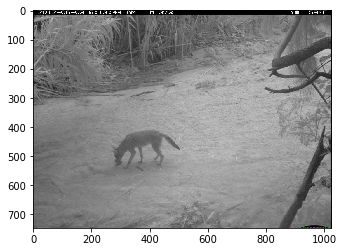

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
# works well
img = get_image('../../../../data/wildcam_subset_sample/train_46/coyote/59817c02-23d2-11e8-a6a3-ec086b02610b.jpg')
#img = get_image('../../../../data/wildcam_subset_sample/train_46/coyote/59e77deb-23d2-11e8-a6a3-ec086b02610b.jpg')
#img = get_image('../../../../data/wildcam_subset_sample/train_46/raccoon/59c669d3-23d2-11e8-a6a3-ec086b02610b.jpg')

#img = get_image('../../../../data/wildcam_subset_sample/test/coyote/592c4d30-23d2-11e8-a6a3-ec086b02610b.jpg')
#img = get_image('../../../../data/wildcam_subset_sample/test/raccoon/58a5313e-23d2-11e8-a6a3-ec086b02610b.jpg'
#img = get_image('../../../../data/wildcam_subset_sample/test/coyote/592c4f32-23d2-11e8-a6a3-ec086b02610b.jpg')
#img = get_image('../../../../data/wildcam_subset_sample/test/coyote/5858bfd9-23d2-11e8-a6a3-ec086b02610b.jpg')
#img = get_image('../../../../data/wildcam_subset_sample/test/coyote/594843d0-23d2-11e8-a6a3-ec086b02610b.jpg')
plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the trained models in Pytorch.

In [4]:
import sys 
sys.path.append('..')
from models import get_net
net = get_net("WILDCAM")

irm_model = net(n_classes=2)
print("loading IRM model")
irm_model.load_state_dict(torch.load("../models/wildcam_denoised_121_0.001_40_10000.0_IRM.pth", map_location="cpu"))
irm_model.to("cpu")

loading IRM model


resnet18_extractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

Get the predicition for our image.

In [5]:
img_t = get_input_tensors(img)
irm_model.eval()
irm_logits = irm_model(img_t)
irm_logits[0]

tensor([-0.9562], grad_fn=<SelectBackward>)

In [6]:
probs = torch.cat((1-F.sigmoid(irm_logits[0]), F.sigmoid(irm_logits[0])), 0)
probs

/home/nisha/anaconda3/envs/irm/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.7224, 0.2776], grad_fn=<CatBackward>)

Predicitions we got are logits. Pass that through sigmoid to get probabilities and class label

In [7]:
probs = torch.cat((1-F.sigmoid(irm_logits[0]), F.sigmoid(irm_logits[0])), 0)
probs.topk(1)
#probs5 = probs.topk(5)

torch.return_types.topk(
values=tensor([0.7224], grad_fn=<TopkBackward>),
indices=tensor([0]))

Getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So 
we need to provide two things: (1) original image as numpy array (2) classification function that would take array of 
perturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take 
resized, cropped image and apply whitening.

In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Define classification function that Lime needs. The input to this function is numpy array of images where each 
image is ndarray of shape (channel, height, width). The output is numpy array of shape (image index, classes) 
where each value in array should be probability for that image, class combination.

In [9]:
def batch_predict(images):
    clf.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clf.to(device)
    batch = batch.to(device)
    
    logits = clf(batch)
    #probs = F.sigmoid(logits)
    probs = torch.cat((1-torch.sigmoid(logits), torch.sigmoid(logits)), 1)
    return probs.detach().cpu().numpy()

test our function for the sample image.

In [10]:
clf = irm_model
test_pred = batch_predict([pill_transf(img), pill_transf(img)])
test_pred

array([[0.72236276, 0.2776372 ],
       [0.72236276, 0.2776372 ]], dtype=float32)

## IRM model explanation
Import lime and create explanation for this prediciton.

In [11]:
from lime import lime_image

In [12]:
explainer = lime_image.LimeImageExplainer(feature_selection='highest_weights', verbose=True, random_state=123)
clf = irm_model
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         #batch_size=100,
                                         random_seed=123) 

100%|#########################################################################|


Intercept 0.40296426593355583
Prediction_local [0.46491433]
Right: 0.2776372
Intercept 0.5970357399600469
Prediction_local [0.53508566]
Right: 0.72236276


In [13]:
explanation.top_labels

[0, 1]

In [14]:
from skimage.segmentation import mark_boundaries

use mask on image and see the areas that are encouraging the top prediction

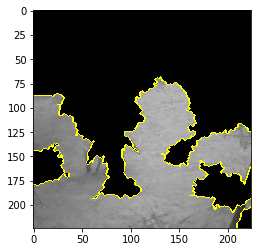

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            negative_only=False,
                                            num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

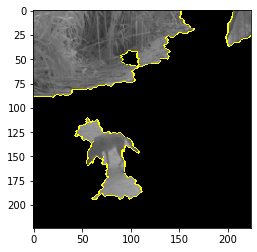

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=True, 
                                            negative_only=False,
                                            num_features=10, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [2]:
explanation.top_labels[0]

NameError: name 'explanation' is not defined

Areas that contribute against the top prediction.

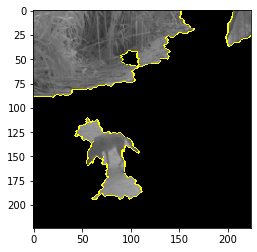

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            negative_only=True,
                                            num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

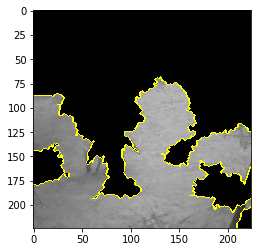

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=False, 
                                            negative_only=True,
                                            num_features=10, hide_rest=True)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [20]:
explanation.local_exp[0]

[(31, 0.06133430157250933),
 (6, -0.03975322837574381),
 (1, -0.03756597587723301),
 (2, -0.03696582748165752),
 (33, -0.035123568029065216),
 (4, -0.03409136026147518),
 (25, 0.031021599953414695),
 (13, -0.023012375791969655),
 (27, 0.022314062467301613),
 (23, 0.02229418464533374),
 (21, 0.021742086062068313),
 (34, 0.019052919035841782),
 (15, 0.018555930456922262),
 (17, 0.018119448494010877),
 (0, -0.016555037260944157),
 (35, 0.01616929284732342),
 (24, -0.015863116923398552),
 (12, -0.01361843391583006),
 (8, -0.011850408731225422),
 (32, -0.01064079238193292),
 (22, 0.010633717904247528),
 (5, -0.009035376716773362),
 (26, 0.008538784634972285),
 (18, -0.008538586459021568),
 (20, 0.008034458886855039),
 (7, -0.006758701488766299),
 (10, -0.006031674075014628),
 (28, -0.005973803066471826),
 (19, -0.005628786482563505),
 (3, -0.0035532008711395926),
 (16, 0.0025617559646040414),
 (29, 0.002550306423128171),
 (14, -0.0018991554145464087),
 (11, -0.0010996533928860587),
 (9, -0.

In [21]:
explanation.local_exp[1]

[(31, -0.061334299893533534),
 (6, 0.039753230761768656),
 (1, 0.03756597453406396),
 (2, 0.03696582918743567),
 (33, 0.03512356774847168),
 (4, 0.034091360149652035),
 (25, -0.031021597848240975),
 (13, 0.023012374318079495),
 (27, -0.02231406554080976),
 (23, -0.022294184388141913),
 (21, -0.02174208736163737),
 (34, -0.019052921229776452),
 (15, -0.018555929887645886),
 (17, -0.01811944840361797),
 (0, 0.016555035248241697),
 (35, -0.0161692907874895),
 (24, 0.015863117146277084),
 (12, 0.013618430386675255),
 (8, 0.011850408728318527),
 (32, 0.010640792716384437),
 (22, -0.010633719926823972),
 (5, 0.009035372730141631),
 (26, -0.008538784076857245),
 (18, 0.008538588106097703),
 (20, -0.008034459866738484),
 (7, 0.00675869965931715),
 (10, 0.006031675590513187),
 (28, 0.0059738029292214405),
 (19, 0.00562878590846052),
 (3, 0.0035532019608672653),
 (16, -0.002561756063525985),
 (29, -0.0025503043214398164),
 (14, 0.0018991555600281638),
 (11, 0.0010996509198319673),
 (9, 0.0007232